In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import copy
import pickle
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import dataset as dt

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

from core.losses import score

### load data

In [59]:
# load dataset
dataset = dt.XTXDataset()
dataset.delete_invalid_rows()

Time series length: 2999999


In [4]:
def acf(data, lag=None):
    n = len(data)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2)
    
    def r(h):
        return np.sum((data[:n-h] - mean) * (data[h:] - mean)) / c0
    
    res = []
    for l in lag:
        res.append(r(l))
    plt.plot(lag, res)
    plt.show()
    
    return res

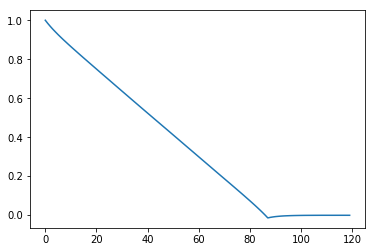

In [50]:
res = acf(dataset.label_y, lag=np.arange(0, 120, 1))

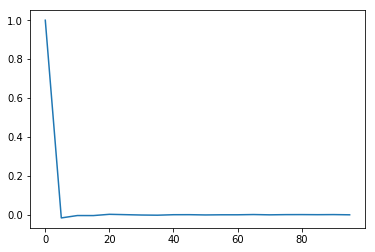

In [5]:
res = acf(np.diff(dataset.mid_rate), lag=np.arange(0, 100, 5))

In [7]:
# res

In [ ]:
mid_rate = dataset.mid_rate
autocorrelation_plot(mid_rate)
plt.show()

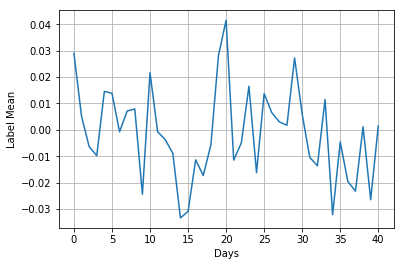

In [61]:
diff_label = dataset.label_y
means = []
for i in range(len(dt.days_index_nonzero)):
    mean = np.mean(diff_label[dt.days_index_nonzero[i]:dt.days_index[i+1]])
    means.append(mean)
plt.plot(means)
plt.xlabel("Days")
plt.ylabel("Label Mean")
plt.grid()
plt.show()

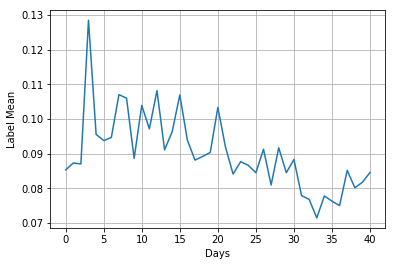

In [35]:
diff_label = np.diff(dataset.mid_rate)
means = []
for i in range(len(dt.days_index_nonzero)):
    mean = np.std(diff_label[dt.days_index_nonzero[i]:dt.days_index[i+1]])
    means.append(mean)
plt.plot(means)
plt.xlabel("Days")
plt.ylabel("Label Mean")
plt.grid()
plt.show()

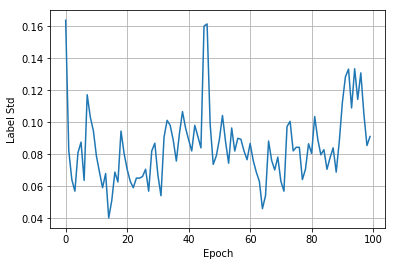

In [50]:
stds = []
n = len(dataset.label_y)
diff_label = np.diff(dataset.mid_rate)
# diff_label = dataset.label_y
step = 1000
for i in range(n // step):
    stds.append(np.std(diff_label[i*step:i*step+step]))
plt.plot(stds[:100])
plt.xlabel("Epoch")
plt.ylabel("Label Std")
plt.grid()
plt.show()

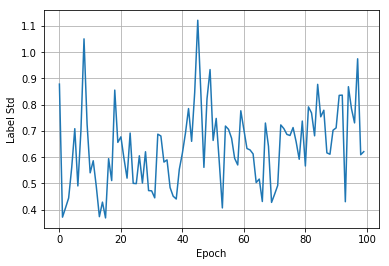

In [49]:
stds = []
n = len(dataset.label_y)
# diff_label = np.diff(dataset.mid_rate)
diff_label = dataset.label_y
step = 1000
for i in range(n // step):
    stds.append(np.std(diff_label[i*step:i*step+step]))
plt.plot(stds[:100])
plt.xlabel("Epoch")
plt.ylabel("Label Std")
plt.grid()
plt.show()

### score by day

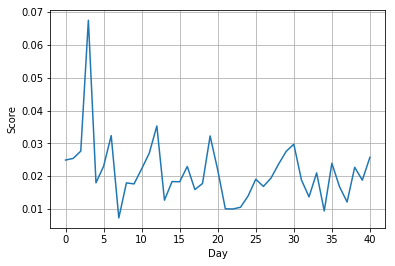

In [60]:
from xtx_model import BaseMLP
from xtx_config import XTX_Config
from core.dataset_utils import volume_data
from core.losses import score

mlp_model = BaseMLP(XTX_Config)
mlp_model.compile()
mlp_model._model.load_weights("datas/weights/scale_2_lastdense_512_val_202_test_199.hdf5")

x, y = volume_data(dataset, XTX_Config["time_steps"], norm_window_size=1, levels=5, split=False)

scores = []
for i in range(len(dt.days_index_nonzero)):
    _x = x[dt.days_index_nonzero[i] : dt.days_index[i+1]]
    _y = y[dt.days_index_nonzero[i] : dt.days_index[i+1]]
    scores.append(score(_y, mlp_model.predict(_x)))

plt.plot(scores)
plt.xlabel("Day")
plt.ylabel("Score")
plt.grid()
plt.show()

In [58]:
x.shape

(2999898, 15, 10)

### predict difference between label

In [ ]:
def diff_label(datas, time_steps, norm_window_size=1, levels=15):
    features = copy(datas.features)
    label = copy(datas.label_y)
    
    ask_rate = np.log10(features[..., 15:15+levels])
    bid_rate = np.log10(features[..., 45:45+levels])
    x = np.concatenate([ask_rate, bid_rate], axis=-1)
    
    label = np.diff(label)
    x = x[1:]

### label standardization

In [ ]:
def label_standardize(label, datas, step=500, ref_length=1000):
    pass

def volume_data_stand_label(datas, time_step, norm_window_size=1, levels=5, delay=87):
    features = copy.copy(datas.features[:-delay])
    label_y = datas.mid_rate[delay:] - datas.mid_rate[:-delay]
    
    # get x
    ask_rate = np.log10(features[..., 15:15 + levels])
    bid_rate = np.log10(features[..., 45:45 + levels])
    x = np.concatenate([ask_rate, bid_rate], axis=-1)
    # label standardization
    std_step, std_ref = 500, 1000
    diff_ = np.diff(datas.mid_rate[delay-1:])
    means = np.ones_like(diff_)
    stds = np.ones_like(diff_)
    for i in range(len(diff_)//step - std_ref//std_step):
        means[i*std_step:i*std_step+std_step] = np.mean(diff_[])
        stds[i*std_step:i*std_step+std_step] = 
    
    # sliding data
    x, y = data_sliding(x, label_y, time_step=time_steps + norm_window_size - 1)

    # split
    (train_x, train_y), (val_x, val_y), (test_x, test_y) = split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

    return (train_x, train_y), (val_x, val_y), (test_x, test_y)
